# Decision Trees and Random Forest #

In this notebook we will see how two closely related classifiers, Decision Tree and Random Forest, work for binary and multi-class classification tasks.  

This tutorial does not implement the algorithms from scratch for big datasets, but explains the idea behind them. For real datasets the `sklearn` python library is used.

## Decision Trees ##

This is a non-parametric, supervised learning method that can be used for both Classification and Regression.

Remember that Decision Trees partition the feature space into a number of smaller (non-overlapping) regions with similar response values (class labels) using a set of splitting rules. In this technique, we split the sample into two or more homogeneous sets (or sub-populations) based on the most significant splitter in input variables. To identify the variable to use at each split, Decision Tree uses a greedy top down algorithm with a kind of stepwise loss function that we will see below.

It is a stepwise function because at each split the algorithm computes which feature to use at that point based on the quality of the split, or how pure it is (less error). And it is greedy beacue it only looks at the features available at that moment, without regard to future splits. To be able to compute the purity of a split we can use the Gini index:

$$
Gini = 1 - \sum ( P(x=k))^2.
$$

Where P(x=k) is the probability that a target label takes a specific value, k.
Basically this index measures how often a randomly chosen element from the set would be incorrectly labled.

Another measure used to determine the splits at each step is the Information Gain, computed as a measure of entropy (as a measure of impurity or randomness):

$$
Entropy(x) = - \sum ( P(x=k)) *  \operatorname{Log}_2 P(x=k)).
$$

The Information Gain tells us how much impurity has improved based on a specific split, so we compare the entropy of the split to the entropy of the data as it is:

$$
Information Gain(feature) = Entropy(dataset) - Entropy(feature).
$$

The feature with the largest information gain should be used as the root node to start building the decision tree. This measure favors smaller partitions with distinct values wheras Gini Index favors larger partitions and it is easy to implement.


## Making a toy Dataset ##

Let's make a simple toy dataset so we can compute the Gini index ourselves.  

Imagine that we love surfing and would like to have a model to predict if there will be good waves in our favorite spot.

The code below creates a data table (called dataframe in `pandas` python library) with information for the independent variables of **wind**, **tide** and **swell size forecast** and the observation that we made about the waves on those days. So our target/dependent variable or classes is a binary categorical variable that tells us whether there are good waves or not based on our features. 

In [ ]:
import pandas as pd
import numpy as np
# define features and target, with values
data = {
    'wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'tide': ['Low', 'Low', 'Low', 'Low', 'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'Low', 'High', 'Low'],
    'swell_forecasting': ['small', 'small', 'medium', 'high', 'high', 'high', 'medium', 'small', 'small', 'high', 'small', 'medium', 'medium', 'high'],
    'good_waves': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

# create dataframe from the dictionary above
data_df = pd.DataFrame(data)
#inspect dataframe. Looking at all 14 lines of it!
data_df.head(14)

To figure out which feature we should use as the root of our tree we should find out which one splits the data best.  

Let's use the Gini index formula above. We do not need this information, but let's first calculate the Gini Index for the dataset as it is as an example. We calculate the probability of belonging to class label `yes` and the probability of belonging to class label `no` by counting the numbers of `yes` and dividing it by the total number of occurences (or, in this case, the size of the dataset) and do the same for `no`.

$$
Gini = 1 - [(9/14)^2 + (4/14)^2] = 0.4591
$$

Now let's calculate this index if we split the data based on swell. Since our variables have different values (for example high, medium and low for swell_forecasting variable), we need to weight our sum by the different value probabilities. It is useful to have a count table so we can easily calculate the probabilities:

In [ ]:
#Count table for swell
swell_count_table = pd.crosstab(index=data_df["swell_forecasting"], 
                            columns=data_df["good_waves"],
                             margins=True)   # Include row and column totals
swell_count_table

Now let's use the table above to compute the Gini Index for the swell variable, It can be a three way split, so we need to compute the probability for each child node (split) times it's Gini Index and summ everything. For the node where swell is high:

$$
P(high) = high/total = 5/14
$$

$$
Gini(high) = 1 - [(2/5)^2 + (3/5)^2] = 0.48
$$

Now let's do the calculation for the whole split:

$$
Gini(swell) = (5/14 * (1 - [(2/5)^2 + (3/5)^2]) +  (4/14 * (1 - [(0/4)^2 + (4/4)^2]) + (5/14 * (1 - [(3/5)^2 + (2/5)^2])= 0.343
$$

Now, can you compute the Gini Index for the other two variables: wind and tide? Remember to use the count table to help you.


In [ ]:
#count table code for wind
wind_count_table = pd.crosstab(index=data_df["wind"], 
                            columns=data_df["good_waves"],
                             margins=True)
wind_count_table

In [ ]:
#Gini index for wind
gini_wind = (6/14 * (1 - ((3/6)**2 + (3/6)**2))) +  (8/14 * (1 - ((2/8)**2 + (6/8)**2)))
print(gini_wind)

In [ ]:
#count table for tide
tide_count_table = pd.crosstab(index=data_df["tide"], 
                            columns=data_df["good_waves"],
                             margins=True)
tide_count_table

In [ ]:
#Gini Index for tide
gini_tide = (7/14 * (1 - ((1/7)**2 + (6/7)**2))) +  (7/14 * (1 - ((4/7)**2 + (3/7)**2)))
#Gini Index for swell (on code!)
gini_swell = (5/14 * (1 - ((2/5)**2 + (3/5)**2))) +  (4/14 * (1 - ((0/4)**2 + (4/4)**2))) + (5/14 * (1 - ((3/5)**2 + (2/5)**2)))
print(gini_swell, gini_wind, gini_tide)

Ok, now that we have all three indexes we choose the best one, based on how pure it is. 

Remember that the Gini Index goes from 0 - completely pure split, where we have observations of only one class in each node; to 0.5 (when we have a binary classification, as is the case here) - split where we have an even mixture of both classes on each node (completley impure or chaotic).

So we choose the split with the lowest Gini for the root node, and here that is the swell!  

Since this is a three way split we divide our dataset in three now to continue our computations. 

In [ ]:
#making a new dataframe for the node high
df1 = data_df[data_df['swell_forecasting'] == 'high']
df1

In [ ]:
#making a new dataframe for the node medium
df2 = data_df[data_df['swell_forecasting'] == 'medium']
df2

In [ ]:
#making a new dataframe for the node small
df3 = data_df[data_df['swell_forecasting'] == 'small']
df3

We can see from our new dataframes that the node medium is composed of observations of only one class, so we can begin contructing our tree like this:

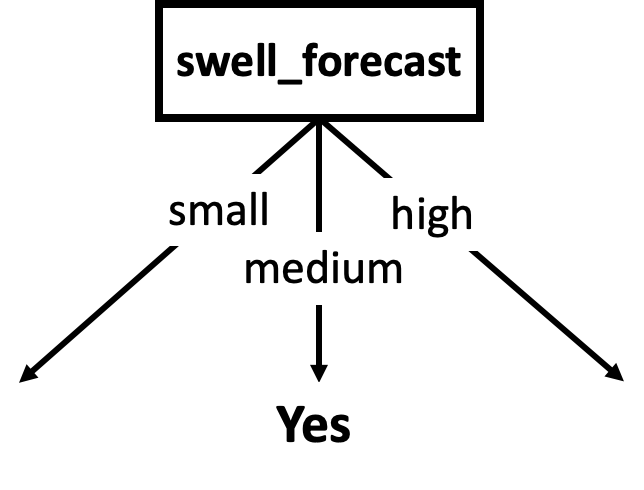

Where the node medium already leads to a leaf node (where the classes are).

Now let's decide which feature to use to slpit each decision node that we have now. We do the same computations as before, but with each new dataset that we have (df1 and df3). Note that we have fewer observations for each dataframe, since now we have splitted the data, and one less variable to decide. We are left with tide and wind.

Let's look at df1:

In [ ]:
#count tables for df1
df1_count_table1 = pd.crosstab(index=df1["tide"], 
                            columns=df1["good_waves"],
                             margins=True)
df1_count_table2 = pd.crosstab(index=df1["wind"], 
                            columns=df1["good_waves"],
                             margins=True)

df1_count_table1, df1_count_table2

We can see that our dataset has decreased substatially, we only have five observations overall! This is one of the issues with decision Trees, we need to have many observations for each class, since at every split our number of observations decreases.  

Let's do the calculations for the Gini index for the rest of the tree. We need to figure out which variable comes next for each of our child nodes. First the child node of high swell_forecasting (df1):

In [ ]:
#Gini Index for tide and wind on df1
gini_tide2 = (3/5 * (1 - ((1/3)**2 + (2/3)**2))) +  (2/5 * (1 - ((1/2)**2 + (1/2)**2)))
gini_wind2 = (2/5 * (1 - ((2/2)**2 + (0/2)**2))) +  (3/5 * (1 - ((0/3)**2 + (3/3)**2)))
print(gini_wind2, gini_tide2)

For this split we have a zero Gini index for wind. Our tree now looks like this:

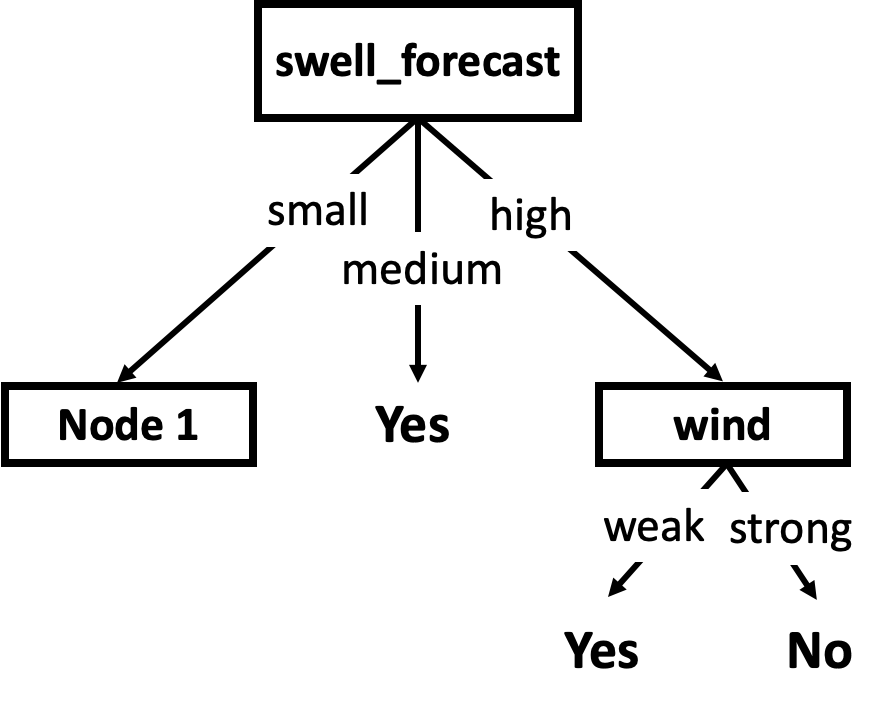

Now let's look at the other node (df3):

In [ ]:
#count tables for df3
df3_count_table1 = pd.crosstab(index=df3["tide"], 
                            columns=df3["good_waves"],
                             margins=True)
df3_count_table2 = pd.crosstab(index=df3["wind"], 
                            columns=df3["good_waves"],
                             margins=True)

df3_count_table1, df3_count_table2

In [ ]:
#Gini Index for tide and wind on df2
gini_tide2 = (2/5 * (1 - ((0/2)**2 + (2/2)**2))) +  (3/5 * (1 - ((3/3)**2 + (0/3)**2)))
gini_wind2 = (2/5 * (1 - ((1/2)**2 + (1/2)**2))) +  (3/5 * (1 - ((2/3)**2 + (1/3)**2)))
print(gini_wind2, gini_tide2)

Now we have a better Gini index for tide and we do the split as the figure below:

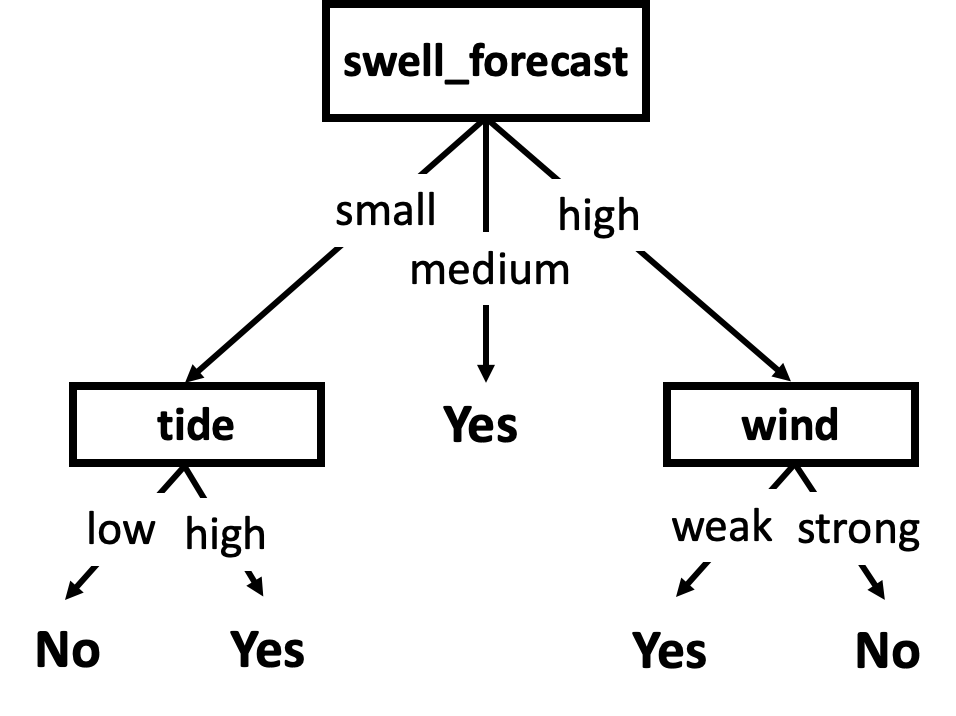

It is a lot of fun and next time we are wondering if we are going to have good waves we just need to folow the rules in our tree! We start at the root, looking to how is the swell forecast. If it is high, we inquire further to see how are the wind conditions, if it is weak we know we will have good waves! What a great day! 

Now let's look at real datasets and learn a little more about this cool algorithm.

## Iris dataset ##

For the multiclass problem let's load the Iris dataset. It consists of petal and sepal width and length measurements for flowers belonging to three different species: _Iris setosa_, _Iris versicolor_ and _Iris virginica_. Below is an image of the flowers. From the image we can see the the species _Iris setosa_ seems to have thiner petals and sepals.

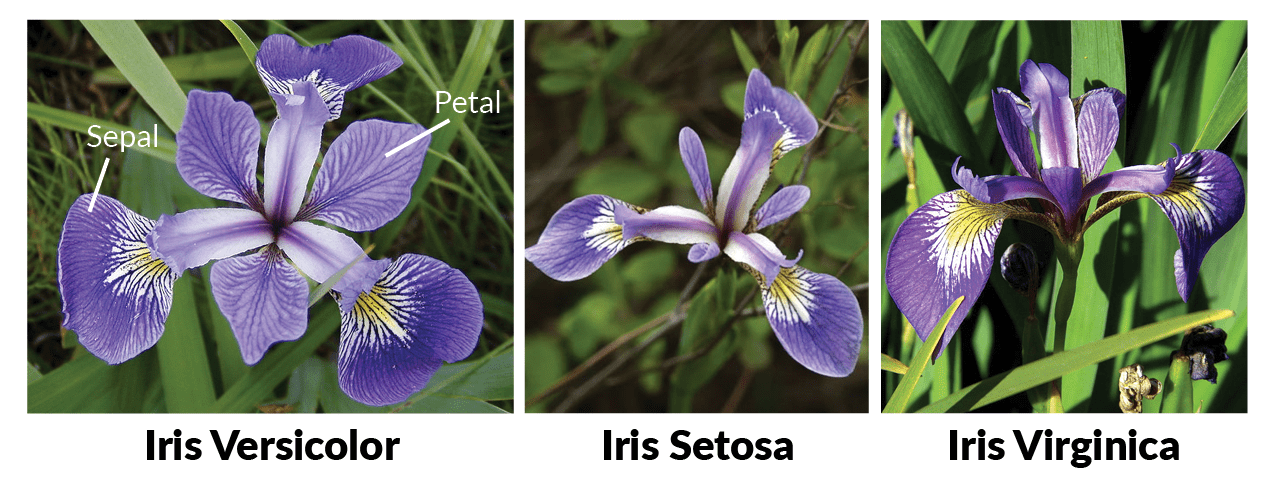

There is a built in `sklearn` function to load this dataset, which, among other information, has a $\mathbb{R}^{150 \times 4}$ data matrix and a $\mathbb{R}^{150}$ target vector in `numpy.ndarray` format. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width. The target names are already encoded as: 0 = setosa, 1 = versicolor and 3 = virginica. 

Let's load and look at the data.

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
X.shape, y.shape

These are the dimensions we were expecting for the data matrix and the vector of target labels!

# Decision Tree with Iris dataset #

Let's make a Decision Tree with the Iris data. In our Iris dataset we have categorical target labels, so we will be doing a classification task. 

Remember, the goal is to create a model that predicts the target label by learning simple decision rules inferred from the data features.

In this data set we have continuous features (length and width) and you will see that the algorithm is able to choose the best sizes to split the data with, along with which feature to use.

This is not a toy dataset anymore, so in order to be able to see how good our model is, we need to have samples for training it and another set of samples, not "seen" by the model to infer how well it generalizes on unseen data. For that we will use `sklearn` train_test_split to split our data into train and test sets. The code below picks out 70% of rows from $X$ randomly, together with corresponding entries of $\vec{y}$, as the 'training set' and leaves the rest out as a 'testing set'.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

There is a built-in `sklearn` function for Decision Trees. We can choose between two measures of impurity: Gini Index or Information Gain (calculated with the entropy).  

The Gini index varies from 0 to 0.5, and the Information Gain from 0 to 1. In both cases the closer to 0 the more pure the split is and, therefore, the more information it contains and less error.  

The default measure is the Gini index, but let's see how different are the results of the two possible impurity measures. We can choose which measure to use by seting the `criterion='gini'` or `criterion='entropy'` when we initialize our model.

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
clf_gini = tree.DecisionTreeClassifier(criterion='gini') # Initialize the model with the parameters chosen
clf_gini = clf_gini.fit(X_train, y_train) # train the model with our data matrix of training samples
pyt=clf_gini.predict(X_test) # making predictions on the test data

#use the accuracy_score function to calculate how accurate are our predictions on the test data
print('Prediction Accuracy:',accuracy_score(pyt, y_test)) 

Now let's do the same with the Information Gain as our measure of impurity:

In [ ]:
clf_info = tree.DecisionTreeClassifier(criterion='entropy') 
clf_info = clf_info.fit(X_train, y_train) 
pyt_info=clf_gini.predict(X_test)

print('Prediction Accuracy:',accuracy_score(pyt_info, y_test))

On this dataset both measures seem to be working similarly! For simple, small datasets this algorithms performs really well without much effort.

Once we trained (fit) the model we can plot the tree:

In [ ]:
tree.plot_tree(clf_gini)

This doesn't look so good! 

We do have the tree depicted in text and in a graphical mode, but it is not aesthetically pleasing. For this we can export the tree in <font color='green'>Graphviz</font> format. If you use the <font color='green'>conda</font> package manager, the graphviz binaries and the python package can be installed with `conda install python-graphviz`. 

This exporter is fun because it supports a variety of aesthetic options, including coloring nodes by their class and using explicit variable and class names. 

Let's try this on our Iris tree:

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

This looks so much better! And it clearly shows the intuitive idea behind Decision Trees, with the different classification rules going each path from the root to each leaf node. For example: beginning at the root, if were to classify a new flower we should ask first if the petal width is smaller or bigger than 0.8cm. If it is smaller or equal to 0.8cm than we would classify this flower as _Iris setosa_. This makes sense with our initial visualization of the flowers, where we saw that this species has much thinner petals and sepatls!

We can also save the tree in an output file called `iris.pdf`:

In [ ]:
graph.render("iris") 

## Madelon dataset ##

This datset is an artificial one that was part of a feature selection challenge. It is composed of a training set with a $\mathbb{R}^{2000 \times 500}$ data matrix and $\mathbb{R}^{2000}$ vector of target labels and validation set with a $\mathbb{R}^{600 \times 500}$ data matrix and $\mathbb{R}^{600}$ vector of target labels. It is a binary classification problem. It can be downloaded from the <a href="https://archive.ics.uci.edu/ml/datasets/madelon">dataset’s</a> homepage.

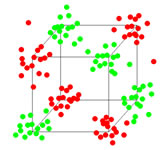

This dataset is interesting because it is a multivariate problem with lots of features (500), which is prone to overfitting. It is also a non linear problem as we se in the image above. Let's see how our Decision Tree classifier does.

First we need to upload the data. The code below will open the files from the UCI website directly and not download them:

In [ ]:
#importing the data
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data"
X_train = np.asarray(pd.read_csv(url1 , header=None, delim_whitespace=True))
url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
y_train = np.asarray(pd.read_csv(url2 , header=None, delim_whitespace=True)).squeeze()
url3 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
X_test = np.asarray(pd.read_csv(url3 , header=None, delim_whitespace=True))
url4 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/madelon_valid.labels'
y_test = np.asarray(pd.read_csv(url4 , header=None, delim_whitespace=True)).squeeze()
#printing the size of each file
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Decision Trees with the Madelon Dataset #

Now let's use the Decision Tree classifier with our Madelon dataset and see how well this classifier perfomrs with a more complex dataset. We will not plot the tree this time, since with this many features it will be a very big one! And we will choose the default Gini Index for spliting. This time let's have a look at how good the classifier is and better understand how overfitting works with different tree depths.

First let's use the classifier with default settings to see how well it works on the test data and also to see what is the best default tree depth. So we will train/fit our model on the train data and see what we get as accuracy for predicitions with this model on the validation/test set.

In [ ]:
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train) 
pyt=clf.predict(X_test)

print('Prediction Accuracy:',accuracy_score(pyt, y_test))

Accuracy was not good at al! We only got the label correctly 73.5% of the time.

What is the depth of the tree?

In [ ]:
clf.get_depth()

# Overfitting Decision Trees with the Madelon Dataset #

Now we can check if using more depth we can improve our score.

The code below computes Decision Trees with varying tree depths: 1 (only the root node) to 10, makes predictions both on train and test data and saves the accuracy scores each time so we can plot them later.

In [ ]:
score_train=[] # a place to record the train acuracy scores
score_test=[] # a place to record the test/validation acuracy scores
tree_depth=list(range(1,11)) #range of tree depths we want to test

for d in tree_depth:
    clf=tree.DecisionTreeClassifier(max_depth=d) #initialize the model with the parameters chosen
    clf.fit(X_train,y_train) #training the model, with the train dataset
    py=clf.predict(X_train) #making predictions on the train dataset
    pyt=clf.predict(X_test) #making predictions on the test dataset
    acc=accuracy_score(py, y_train) #calculating accuracy score for the predictions on train dataset
    acct=accuracy_score(pyt, y_test) #calculating accuracy score for the predictions on test dataset
    score_train.append(acc) #appedning our score results to the list initialized above
    score_test.append(acct) #appedning our score results to the second list initialized above
    print(f'Tree Depth: {d}, Prediction Accuracy for train: {acc}, and test: {acct}')
    

Now let's plot these scores!

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.autoscale()
plt.title("Accuracy scores versus tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.xlim(0,11,1)
plt.plot(tree_depth,score_train, label="Train")
plt.plot(tree_depth,score_test, label="Test")
plt.legend(loc='upper left')
plt.show()

With the plot we can see that accuracy for the train data always increases with the tree depth, with more complex models. Nevertheless, the test data accuracy score increases up to 0.798 with a tree depth of 6 and then starts decreasing with more depth. This tells us that with more complexity than a tree depth of 6 our model starts to not generalize well and is overfitting the train data.

## Forest Cover Dataset ##

The samples in this dataset correspond to 30×30m patches of forest in the US. The task is to predict each patch’s cover type, i.e. the dominant species of tree. There are seven cover types, making this a multiclass classification problem. Each sample has 54 features, described on the <a href="https://archive.ics.uci.edu/ml/datasets/Covertype">dataset’s</a> homepage. Some of the features are boolean indicators (like the soil types), while others are discrete or continuous measurements.

There is a built in `sklearn` function to load this dataset, which, among other information, has the $\mathbb{R}^{581012 \times 54}$ data matrix and $\mathbb{R}^{581012}$ vector of target labels in a `numpy.ndarray`. This is an interesting dataset with many samples (581012) and variables (54). We can also download the data in a <font color='green'>pandas</font> dataframe format, if we set the '`as_frame=True`. Let's do this and look at the first few lines of the dataframe to get a feeling for the variables used.

In [ ]:
import pandas as pd
covtype = datasets.fetch_covtype(as_frame=True) 
X = covtype.data
y = covtype.target
frame = covtype.frame
frame.head()

This dataset is big, so spliting the data into train and test/validation sets to see how our model perfomrs in the end makes even more sense!

Let's do the train test split for our Land Cover dataset in the same way we did for the Iris dataset:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Decision Tree with Forest Cover dataset #

Now let's use the Decision Tree classifier with our CoverType dataset and see how well this classifier perfomrs with a big dataset but with smaller numbers of features than the previous one. Again, let's use the default Gini Index for spliting. 

In [ ]:
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train) 
pyt=clf.predict(X_test)

print('Prediction Accuracy:',accuracy_score(pyt, y_test))

The accuracy score is not as good as we found for the Iris dataset, but much better than the one we found for the Madelon dataset with just the default settings!

`sklearn` has really good <a href="https://scikit-learn.org/stable/modules/tree.html">tips</a> on how to better model your data with decision trees.

But instead of trying to better model a Decision Tree, let's see how an ensemble of Decision Trees will benefit us. Let's try the Random Forest classifier and see if we get better resuls. 

# Random Forest with Forest Cover dataset #

Now let's take a look at the same dataset and classification problem with the Random Forest algorithm. Remember that Random Forest is an ensemble method for Decision trees, so it aggregates the output of a number of simpler Decision Tree classifiers into a final classification. 

The idea behind Random Forest is that the trees protect each other from their individual errors (as long as they don’t constantly all err in the same direction). While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction. 

So the prerequisites for random forest to perform well are:

- There needs to be some actual signal in our features so that models built using those features do at least a little better than random guessing.  
- The predictions (and therefore the errors) made by the individual trees need to have low correlations with each other.  

The assurance that we will not have correlated trees comes from the randomness inputed by the algorithm in two places:

**1)** For each Decision tree classifier used, the samples are bootstrapped (sampling with replacement) from the original data. So, although we do have the same size data, some instances will not be sampled and others will be sampled more than once.  

**2)** For each Decision Tree classifier we will not decide on each feature to split based on all features but a smaller number (the default is the square root of the number of features). This means that even though a feature might have a better impurity measure than the rest to start with, it might not be in the feature selection we are looking at the moment!


There is a built-in `sklearn` function for Random Forest. This algorithm is part of the ensamble group in `sklearn` and there is a good <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble">documentation</a> talking all about the different ensemble methods. Right now we will only look at the default settings, with 100 trees in the forest (`n_estimators=100`), the Gini index as our metric of impurity, the number of features used for each split will be the square root of the number of features (`max_features='auto'`), and using a bootstrapped sample of the dataset (`bootstrap=True`).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
pyt=clf.predict(X_test)

print('Prediction Accuracy:',accuracy_score(pyt, y_test))

Reasonable score!

Some improvement from the one Decision Tree classifier used before and we did not tweak the parameters! But it did take us longer.

Now let's try using more than the default 100 trees. The code below is similar to the one we used for the different tree depths with the Decision tree classifier. Now we are going to do Random forest three times, each time with more trees. For that we need to change the `n_estimators` number when initializing the model. The code does take a few minutes to run.

In [ ]:
score_train=[]
score_test=[]
n_trees=[200,300,500]
for t in n_trees:
    clf=RandomForestClassifier(n_estimators=t)
    clf.fit(X_train,y_train)
    py=clf.predict(X_train)
    pyt=clf.predict(X_test)
    acc=accuracy_score(py, y_train)
    acct=accuracy_score(pyt, y_test)
    score_train.append(acc)
    score_test.append(acct)
    print(f'Number of Trees: {t}, Prediction Accuracy for train: {acc}, and test: {acct}')
    

Although we would think more trees would improve our model, there isn't much improvement with this dataset! Nevertheless, it is something to experiment with other datasets. It does take a longer time to run though. Other parameters to tweak would be the number of features used in each split, whether to bootstrap the samples or not and much <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">more</a>. 

Let's see what changing the number of features used in each split does to our model. This code takes a few minutes to run on an average desktop.

In [ ]:
score_train=[]
score_test=[]
features=[7,10,15,20, 30, 40]
for f in features:
    clf=RandomForestClassifier(max_features=f)
    clf.fit(X_train,y_train)
    py=clf.predict(X_train)
    pyt=clf.predict(X_test)
    acc=accuracy_score(py, y_train)
    acct=accuracy_score(pyt, y_test)
    score_train.append(acc)
    score_test.append(acct)
    print(f'Number of features: {f}, Prediction Accuracy for train {acc} and test: {acct}')
    

Let's plot these results to better understand what we have:

In [ ]:
fig, ax = plt.subplots()
ax.autoscale()
plt.title("Accuracy scores versus number of features")
plt.xlabel("Number of features used for each split")
plt.ylabel("Accuracy")
plt.plot(features,score_train, label="Train")
plt.plot(features,score_test, label="Test")
plt.legend(loc='lower right')
plt.show()

It certainly makes the process slower. But it does improve our predictions of the test set a little. Nevertheless, after 20 features it does not seem to improve as much and takes a lot more time to run.  

So, as long as you have the luxury of being able to have a train and a separate validation/test set for your data, tweaking the parameters for the Decision Tree and Random Forest classifiers might help you get a better model. And these are simple, intuitive and not really expensive (computationally) models to run.  

For Decision Trees you even get a set of rules for classification and a picture of a tree to go witht he rules to better explain your model. This algorithm is also great to better inform you on the importance of your features for the classification task, since, in the end, it only uses the features that help you split the data in more homogenous sets.